In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [383]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
words = open('names.txt', 'r').read().splitlines()
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [4]:
chars = ''.join(sorted(set(''.join(words))))
chars

stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [551]:
block_size = 4  # context length: how many characters to look back

def build_ds(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n = len(words)
n1 = int(n * 0.8)
n2 = int(n * 0.9)

Xtr, Ytr = build_ds(words[:n1])
Xdev, Ydev = build_ds(words[n1:n2])
Xte, Yte = build_ds(words[n2:])


In [635]:
dim = 16
hidden = 256
C = torch.randn((27, dim), requires_grad=True)
g = torch.Generator().manual_seed(42)

w1 = torch.randn((dim * block_size, hidden), generator=g, requires_grad=True)
b1 = torch.randn((hidden,), generator=g, requires_grad=True)

w12 = torch.randn((hidden, hidden), generator=g, requires_grad=True)
b12 = torch.randn((hidden,), generator=g, requires_grad=True)

w2 = torch.randn((hidden, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
# params = [C, w1, b1, w2, b2, w12, b12]
params = [C, w1, b1, w2, b2]


losses = []
grads_abs_mean = []
sum([p.nelement() for p in params])

24011

In [636]:


def eval(x, y):
    emb = C[x]
    h = torch.tanh(emb.view(-1, dim * block_size) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()
    # print(x.shape[1], loss.item())


for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (128,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    emb = C[x]
    h = torch.tanh(emb.view(-1, dim * block_size) @ w1 + b1)
    # h = torch.tanh(h @ w12 + b12)
    logits = h @ w2 + b2

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # -prob[torch.arange(4), Y[:4]].log().mean(), F.cross_entropy(logits, Y[:4])

    loss = F.cross_entropy(logits, y)

    for p in params:
        p.grad = None
    loss.backward()
    losses.append(loss.item())

    lr = 0.1
    if i > 100000: lr = 0.01
    if i % 10000 == 0:
        print(f'{i}, test: {eval(Xdev, Ydev):.5f}, train: {eval(Xtr, Ytr):.5f}')

    for p in params:
        p.data -= p.grad * 0.1



0, test: 27.65188, train: 27.54079
10000, test: 2.46517, train: 2.43419
20000, test: 2.34261, train: 2.30997
30000, test: 2.28792, train: 2.24458
40000, test: 2.28250, train: 2.24095
50000, test: 2.25513, train: 2.20687
60000, test: 2.25057, train: 2.19979
70000, test: 2.22237, train: 2.17173
80000, test: 2.20048, train: 2.14466
90000, test: 2.20071, train: 2.13865
100000, test: 2.21379, train: 2.14529
110000, test: 2.18473, train: 2.11599
120000, test: 2.18797, train: 2.11211
130000, test: 2.17781, train: 2.09319
140000, test: 2.17406, train: 2.09302
150000, test: 2.18541, train: 2.09796
160000, test: 2.16492, train: 2.07242
170000, test: 2.16932, train: 2.07565
180000, test: 2.15562, train: 2.05922
190000, test: 2.16025, train: 2.05866


In [634]:
import numpy
torch.set_printoptions(sci_mode=False, precision=4)

from collections import Counter

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(-1, dim * block_size) @ w1 + b1)
        # h = torch.tanh(h @ w12 + b12)
        logits = h @ w2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, replacement=True).item()
        if ix == 0:
            
            break

        out.append(ix)
        context = context[1:] + [ix]
    print(''.join(itos[i] for i in out))

# freqs = Counter(ix.view(-1).tolist())
# plt.figure(figsize=(30, 10))
# x = freqs.keys()
# plt.bar(x, freqs.values())
# plt.xticks(ticks=x)


# plt.hist(ix.view(-1).numpy(), bins=26)

kazan
zyoarri
neda
mikf
kemaydon
ryyah
arkanio
emmlee
arnie
zabat
dipphire
kolynn
kenth
firsly
parleyah
nahariveen
dill
kaziyah
rovion
ezola


In [476]:
# plt.plot(10 ** torch.linspace(-3, 0, 100))
# plt.plot(lrs, losses)
for p in params:
    print(p.grad.abs().mean().item(), p.shape, p.grad.mean().item(), p.grad.std().item())

0.007408410310745239 torch.Size([27, 32]) 0.0006000390858389437 0.011399585753679276
0.002261834917590022 torch.Size([96, 200]) 1.4525800906994846e-05 0.0032279849983751774
0.0018330737948417664 torch.Size([200]) 0.00020467022841330618 0.0024487387854605913
0.010478814132511616 torch.Size([200, 27]) 4.415158863513291e-11 0.014366596937179565
0.011084049008786678 torch.Size([27]) -3.3631092355435044e-10 0.01574217714369297


In [504]:
C[10,0]

tensor(-0.2352, grad_fn=<SelectBackward0>)

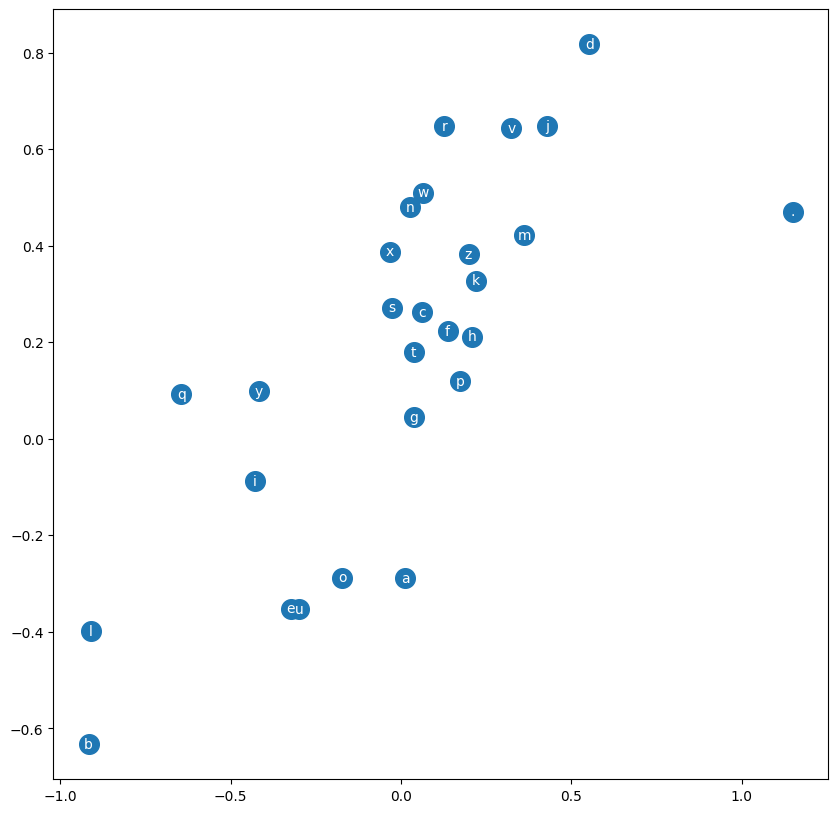

In [516]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:,2].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 2].item(), C[i, 1].item(), itos[i], color='white', ha='center', va='center')


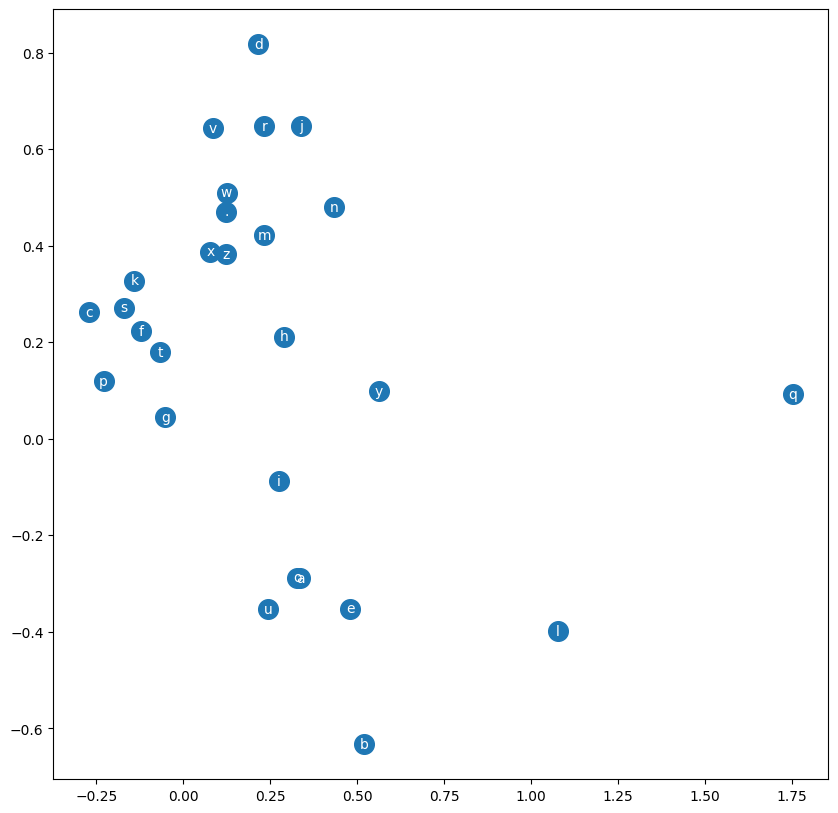

In [515]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], color='white', ha='center', va='center')


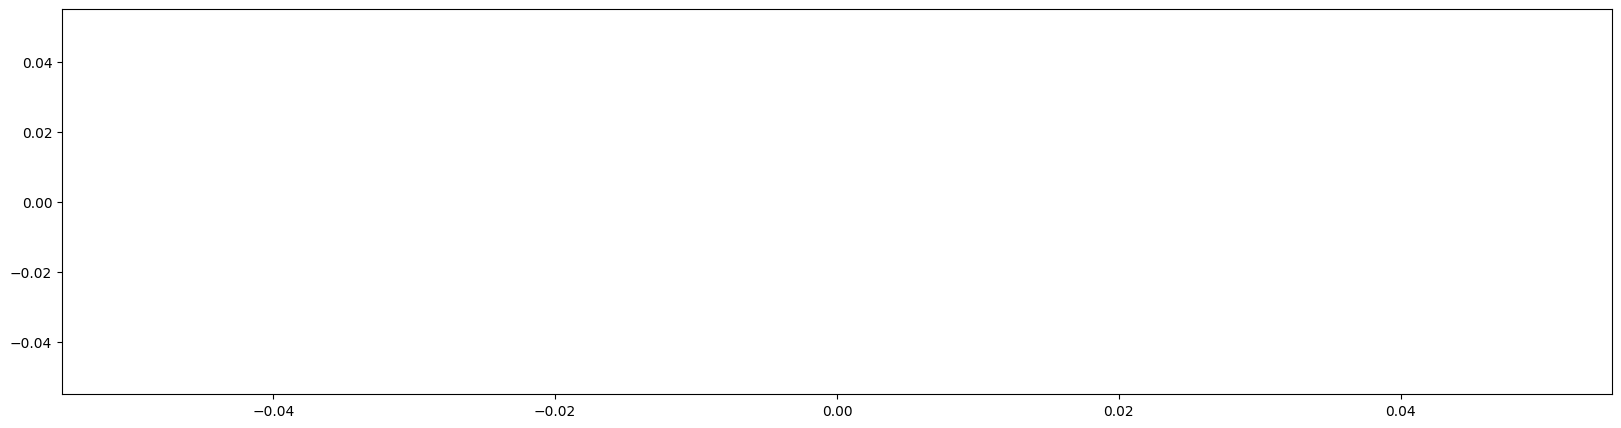

In [533]:
ax = plt.figure(figsize=(20, 5))
plt.plot(grads_abs_mean)

(array([ 12.,   9.,  30.,  31.,  71., 128., 155., 204., 376., 477., 466.,
        259., 191., 102., 102.,  36.,  23.,  18.,   8.,   2.]),
 array([-0.0384731 , -0.0344864 , -0.03049971, -0.02651301, -0.02252632,
        -0.01853962, -0.01455293, -0.01056623, -0.00657954, -0.00259285,
         0.00139385,  0.00538054,  0.00936724,  0.01335393,  0.01734063,
         0.02132732,  0.02531401,  0.02930071,  0.0332874 ,  0.0372741 ,
         0.04126079]),
 <BarContainer object of 20 artists>)

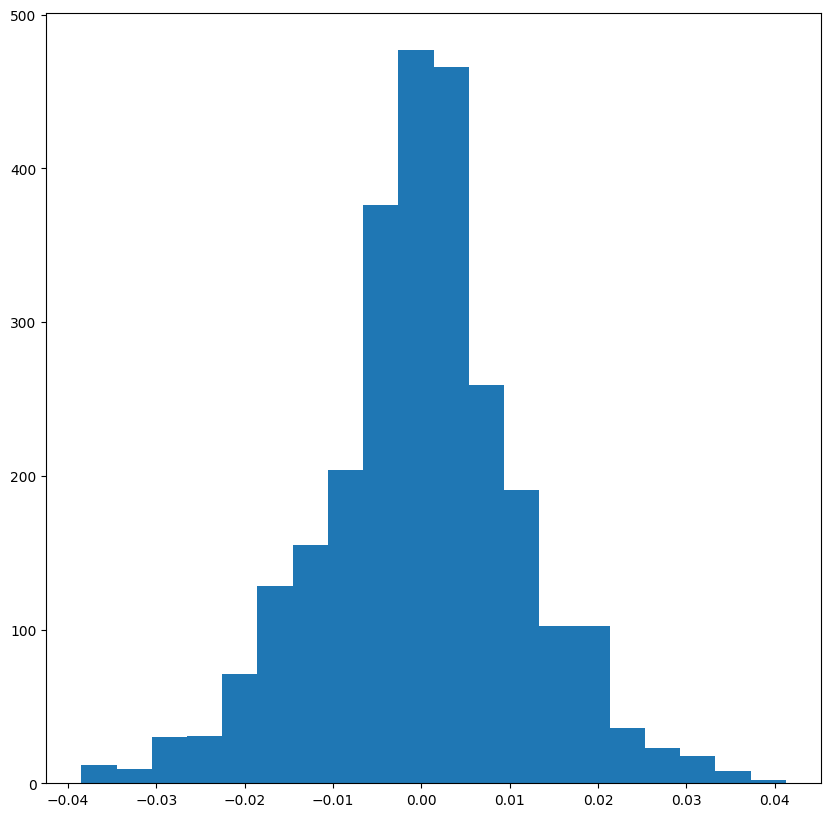

In [525]:
plt.figure(figsize=(10, 10))
plt.hist(w2.grad.view(-1).detach().numpy(), bins=20)


In [337]:
def compress_grads(params):
    all_grads = []
    for p in params:
        all_grads.extend(p.grad.flatten().tolist())

    import struct
    grad_bytes = b''.join(struct.pack('i', int(f * 100000)) for f in all_grads)
    
    # Compress the bytes using zlib
    import zlib
    compressed_grads = zlib.compress(grad_bytes)

    print(len(all_grads), len(compressed_grads), len(grad_bytes))

In [338]:
compress_grads(all_grads)


10187 19983 40748


In [88]:
import numpy

a = numpy.array([1, 2, 3])
t = torch.from_numpy(a)
a[1] = 1
a, t, t.numpy()

x = torch.randn(2, 3, 5)
x, x.permute(2, 0, 1)

(tensor([[[-1.0204, -0.3262, -0.8112, -0.0609,  0.2713],
          [ 0.9692, -0.3279, -2.1037,  0.5561,  0.3346],
          [ 0.2576,  1.9321, -0.9809, -1.4207,  0.9202]],
 
         [[-0.4995, -0.6821,  0.5648, -0.1015, -1.1464],
          [-0.7195, -0.3031, -0.3871, -0.2781,  0.3773],
          [ 0.7610,  0.2097, -0.8640, -1.1704, -0.6160]]]),
 tensor([[[-1.0204,  0.9692,  0.2576],
          [-0.4995, -0.7195,  0.7610]],
 
         [[-0.3262, -0.3279,  1.9321],
          [-0.6821, -0.3031,  0.2097]],
 
         [[-0.8112, -2.1037, -0.9809],
          [ 0.5648, -0.3871, -0.8640]],
 
         [[-0.0609,  0.5561, -1.4207],
          [-0.1015, -0.2781, -1.1704]],
 
         [[ 0.2713,  0.3346,  0.9202],
          [-1.1464,  0.3773, -0.6160]]]))

In [113]:
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
loss = F.binary_cross_entropy(torch.sigmoid(input), target)
# loss.backward()

In [127]:
numpy.log(1/27)

np.float64(-3.295836866004329)

(tensor([[0.3567, 0.4047],
         [0.9544, 0.8270],
         [0.9609, 0.8268]]),
 tensor([[0.4709, 0.4627],
         [0.4560, 0.5313],
         [0.7999, 0.5339]], grad_fn=<SigmoidBackward0>))